# Smoothing Splines

This notebook shows several examples of smoothing splines.

## BSpline

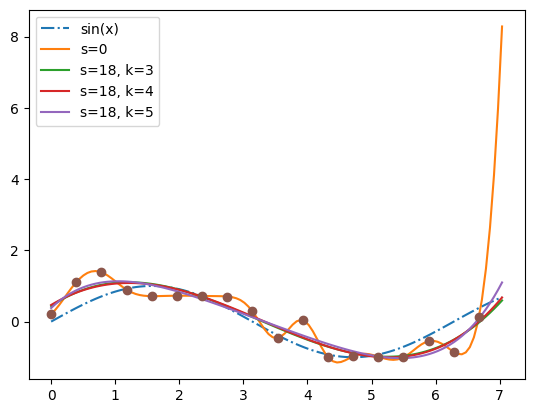

In [1]:
# Example from https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

import numpy as np
from scipy.interpolate import make_splrep

x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/16)
rng = np.random.default_rng()
y =  np.sin(x) + 0.4*rng.standard_normal(size=len(x))

import matplotlib.pyplot as plt
xnew = np.arange(0, 9/4, 1/50) * np.pi

plt.plot(xnew, np.sin(xnew), '-.', label='sin(x)')
plt.plot(xnew, make_splrep(x, y, s=0, k=4)(xnew), '-', label='s=0')
plt.plot(xnew, make_splrep(x, y, s=len(x), k=3)(xnew), '-', label=f's={len(x)}, k=3')
plt.plot(xnew, make_splrep(x, y, s=len(x), k=4)(xnew), '-', label=f's={len(x)}, k=4')
plt.plot(xnew, make_splrep(x, y, s=len(x), k=5)(xnew), '-', label=f's={len(x)}, k=5')
plt.plot(x, y, 'o')
plt.legend()
plt.show()

## BSpline in application to gaits trajectory approximation

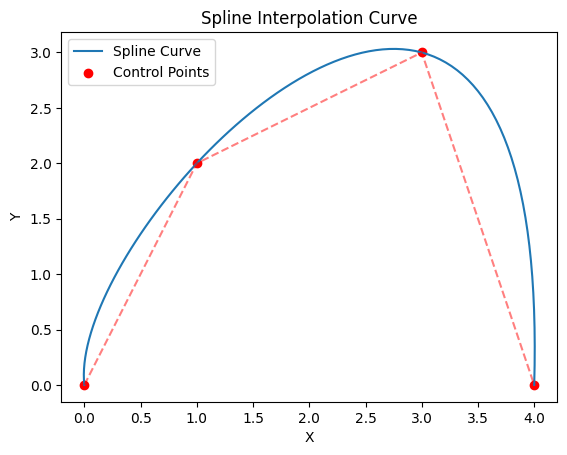

In [2]:
from scipy.interpolate import make_interp_spline



def bezier_spline(control_points, num_points=100):
    """
    Compute a smooth spline interpolation of control points using make_interp_spline.

    :param control_points: List of control points [(x0, y0), (x1, y1), ...]
    :param num_points: Number of points in the interpolated curve
    :return: Interpolated curve points
    """
    control_x, control_y = zip(*control_points)
    t = np.linspace(0, 1, len(control_points))

    spline_x = make_interp_spline(t, control_x, k=3)
    spline_y = make_interp_spline(t, control_y, k=3)

    return spline_x, spline_y

control_points = np.array([[0, 0], [1, 2], [3, 3], [4, 0]])

spline_x, spline_y = bezier_spline(control_points)


# Plot curve and control points
control_x, control_y = zip(*control_points)

# Evaluate the spline at a sequence of points
t = np.linspace(0, 1, 100)
curve_x = spline_x(t)
curve_y = spline_y(t)

plt.plot(curve_x, curve_y, label='Spline Curve')
plt.scatter(control_x, control_y, color='red', label='Control Points')
plt.plot(control_x, control_y, 'r--', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spline Interpolation Curve')
plt.show()


## Bezier curve using B-spline

The SciPy's BSpline class can represent Bezier curves, as Bezier curves are a special case of B-splines.

To define a Bezier curve in SciPy, one needs to specify the control points and the degree of the curve. For example, a cubic Bezier curve (degree 3) requires four control points. The BSpline class then creates a spline object, which can be evaluated at any point to obtain the corresponding point on the curve.

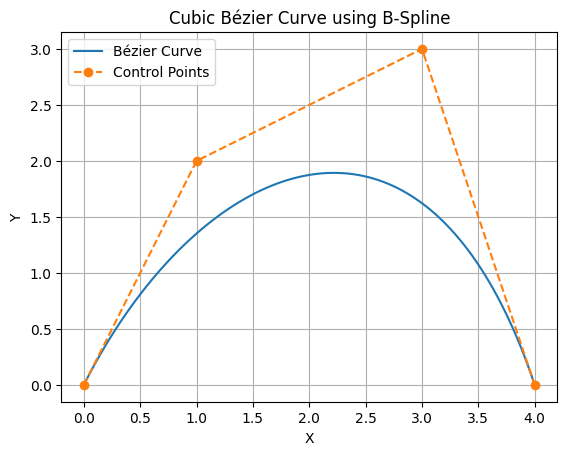

In [3]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

# Define control points for a cubic Bezier curve
control_points = np.array([[0, 0], [1, 2], [3, 3], [4, 0]])

# Define the degree of the curve (cubic)
degree = 3

# Create a clamped knot vector for a cubic Bézier curve with 4 control points
knots = [0, 0, 0, 0, 1, 1, 1, 1]

# Create the BSpline object (each coordinate must be passed separately)
spl_x = BSpline(knots, control_points[:, 0], degree)
spl_y = BSpline(knots, control_points[:, 1], degree)

# Evaluate the spline at a sequence of points
t = np.linspace(0, 1, 100)
curve_points_x = spl_x(t)
curve_points_y = spl_y(t)

# Plot the curve and control points
plt.plot(curve_points_x, curve_points_y, label='Bézier Curve')
plt.plot(control_points[:, 0], control_points[:, 1], 'o--', label='Control Points')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cubic Bézier Curve using B-Spline")
plt.grid()
plt.show()


## Pure python implementation of Bézier curve

Here's a pure Python function for a Bézier curve of any degree, parameterized by $t$ in the range $[0,1]$. It uses the Bernstein polynomial form to compute the interpolated point for a given $t$.

### Bezier Interpolation

This function computes a Bézier curve point for a given $t$ by iterating through control points and applying the Bernstein polynomial formula.

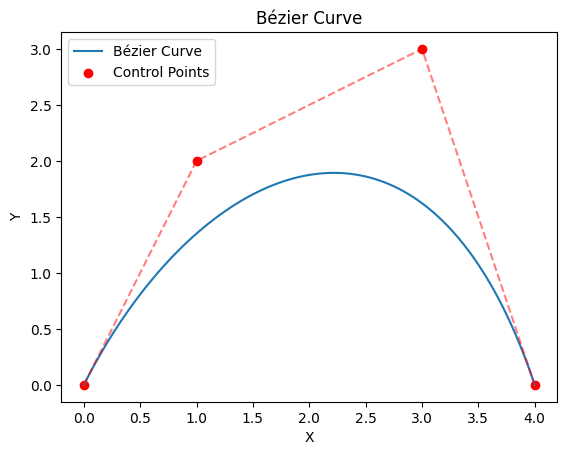

In [14]:
from math import comb
import matplotlib.pyplot as plt


def bezier_curve(control_points:np.ndarray, t):
    """
    Compute a point on a Bézier curve using the Bernstein polynomial form.

    :param control_points: List of control points [(x0, y0), (x1, y1), ...]
    :param t: Parameter in range [0,1]
    :return: (x, y) coordinate of the curve at parameter t
    """
    control_points = np.array(control_points)
    n = len(control_points) - 1
    result = np.zeros(control_points.shape[1])

    for i, p in enumerate(control_points):
        bernstein = comb(n, i) * (t**i) * ((1 - t) ** (n - i))
        result += bernstein * p

    return result


# Example usage
control_pts = [(0, 0), (1, 2), (3, 3), (4, 0)]
t_values = [i / 100 for i in range(101)]
points = [bezier_curve(control_pts, t) for t in t_values]

# Plot curve and control points
curve_x, curve_y = zip(*points)
control_x, control_y = zip(*control_pts)

plt.plot(curve_x, curve_y, label='Bézier Curve')
plt.scatter(control_x, control_y, color='red', label='Control Points')
plt.plot(control_x, control_y, 'r--', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bézier Curve')
plt.show()


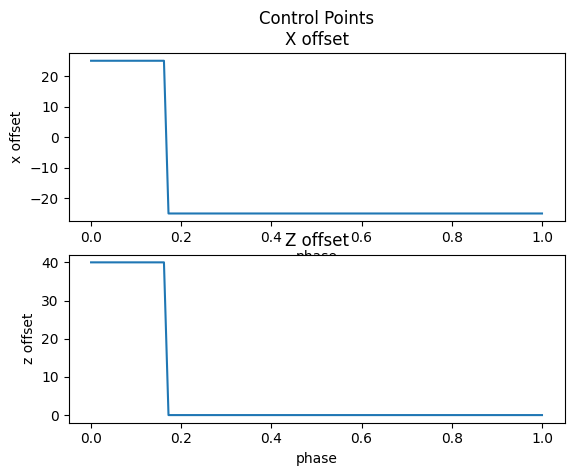

In [9]:
phase = np.linspace(0, 1, 100)

def leg_control_point(phase):
  lift_duration = 1 / 6
  step_height = 40
  half_step = 50 / 2

  if phase < lift_duration:
      # Swing phase - leg in air moving forward
      x_control_point = half_step
      z_control_point = step_height
  else:
      # Stance phase - leg on ground moving backward
      x_control_point = -half_step
      z_control_point = 0  # On ground

  return x_control_point, z_control_point

fig, ax = plt.subplots(2, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Control Points\nX offset')
ax[0].plot(phase, [leg_control_point(p)[0] for p in phase])

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, [leg_control_point(p)[1] for p in phase])

plt.show()

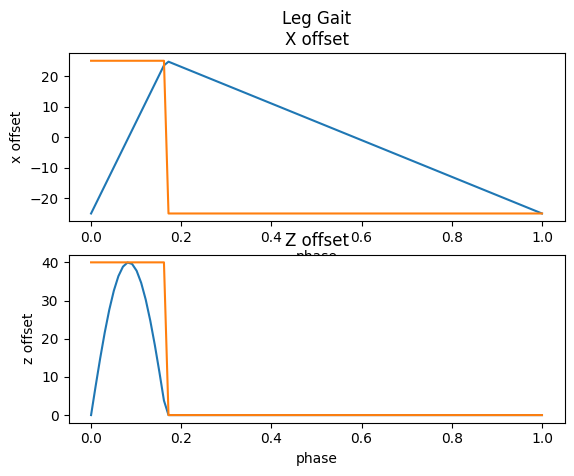

In [10]:
phase = np.linspace(0, 1, 100)

def leg_gait_point(phase):
  lift_duration = 1 / 6
  step_height = 40
  half_step = 50 / 2

  if phase < lift_duration:
      # Swing phase - leg in air moving forward
      t = np.interp(phase, [0, lift_duration], [0, 1])
      x_control_point = np.interp(phase, [0, lift_duration], [-half_step, half_step])
      z_control_point = np.sin(t * np.pi) * step_height
  else:
      # Stance phase - leg on ground moving backward
      x_control_point = np.interp(phase, [lift_duration, 1], [half_step, -half_step])
      z_control_point = 0  # On ground
  
  return x_control_point, z_control_point

fig, ax = plt.subplots(2, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Leg Gait\nX offset')
ax[0].plot(phase, [leg_gait_point(p)[0] for p in phase])
ax[0].plot(phase, [leg_control_point(p)[0] for p in phase])

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, [leg_gait_point(p)[1] for p in phase])
ax[1].plot(phase, [leg_control_point(p)[1] for p in phase])

plt.show()

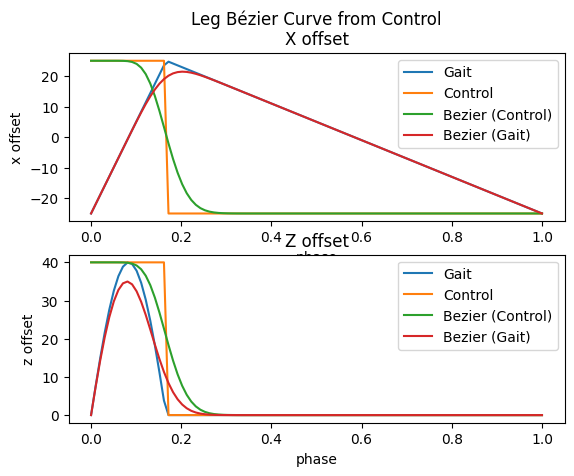

In [24]:
gait_points = np.array([leg_gait_point(p) for p in phase])
control_pts = np.array([leg_control_point(p) for p in phase])

bezier_control_pts = np.array([bezier_curve(control_pts, t) for t in phase])
bezier_gaits_points = np.array([bezier_curve(gait_points, t) for t in phase])

fig, ax = plt.subplots(2, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Leg Bézier Curve from Control\nX offset')
ax[0].plot(phase, gait_points[:, 0], label='Gait')
ax[0].plot(phase, control_pts[:, 0], label='Control')
ax[0].plot(phase, bezier_control_pts[:, 0], label='Bezier (Control)')
ax[0].plot(phase, bezier_gaits_points[:, 0], label='Bezier (Gait)')

ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, gait_points[:, 1], label='Gait')
ax[1].plot(phase, control_pts[:, 1], label='Control')
ax[1].plot(phase, bezier_control_pts[:, 1], label='Bezier (Control)')
ax[1].plot(phase, bezier_gaits_points[:, 1], label='Bezier (Gait)')

ax[1].legend()
